In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2

from skimage.feature import hog, graycomatrix, graycoprops
from skimage import exposure
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# DIR = './paintings/new/'
DIR = './paintings/artists/'
# STYLES = ['Impressionism', 'Realism', 'Romanticism', 'Expressionism',
#          'Art Nouveau (Modern)', 'Surrealism', 'Baroque']

H = 526 # shape[0]
W = 538 # shape[1]

PATCH_SIZE = 35
GLSM_FEATURES = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']

#### Собирание набора данных (2)

In [3]:
ARTISTS = os.listdir(DIR)

arr = []
artists = []
for artist in ARTISTS:
    filenames = os.listdir(DIR+artist)
    arr.append([artist+'/'+i for i in filenames])
    artists.append([artist for i in range(len(filenames))])
arr = list(np.array(arr).ravel())
artists = list(np.array(artists).ravel())
df = pd.DataFrame([arr, artists]).T
df.columns = ['filename', 'artist']

le = LabelEncoder()
df['label'] = le.fit_transform(df['artist'])

#### Собирание набора данных (1)

In [2]:
info = pd.read_csv('./paintings/train_info.csv')
files = [i for i in os.listdir('./paintings/new/') if '.jpg' in i]
df = info[info.filename.isin(files)]
df = df.sample(frac=1).reset_index(drop=True)

le = LabelEncoder()
df['label'] = le.fit_transform(df['style'])

def get_mean_w_and_h():
    filenames = os.listdir('./paintings/new/')
    sh0, sh1, num = 0, 0, 0
    for file in filenames:
        img = cv2.imread(DIR+file)
        sh0 += img.shape[0]
        sh1 += img.shape[1]
        num += 1
    print(round(sh0/num), 'на', round(sh1/num)) 
    # 1077 на 1053

# files = [i for i in os.listdir('./paintings/') if '.jpg' in i]    

# df = info[info['style'].isin(STYLES) & info['filename'].isin(files)]
# filenames = []
# for style in STYLES:
#     filenames.append(df[df['style']==style].sample(100).filename.to_numpy())
# filenames = np.array(filenames).ravel()

# # os.mkdir('./paintings/new')
# for file in filenames:
#     os.rename(f'C:/Users/Asus/Desktop/учеба/4 курс/Биометрия/paintings/{file}', f'C:/Users/Asus/Desktop/учеба/4 курс/Биометрия/paintings/new/{file}')

#### Примеры картин на каждый класс/художницу

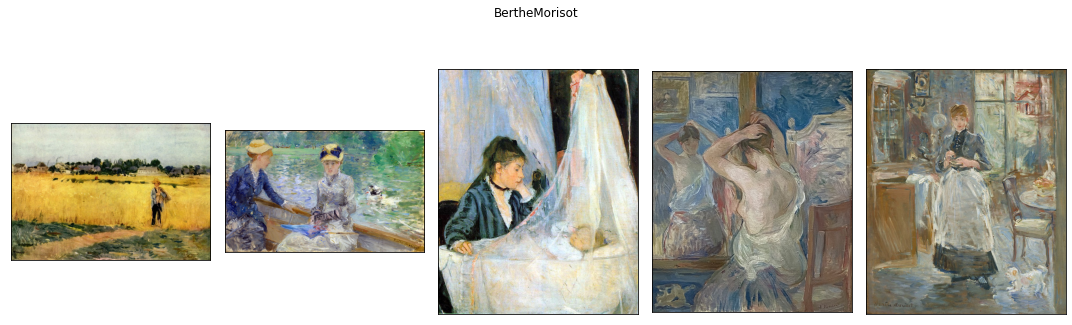

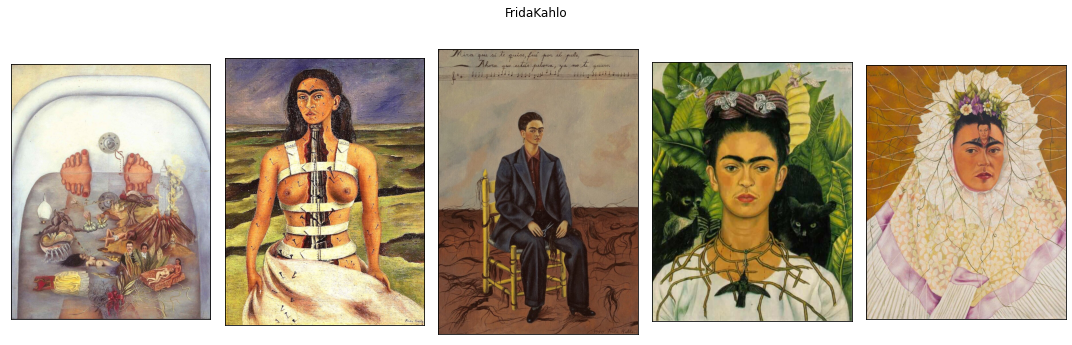

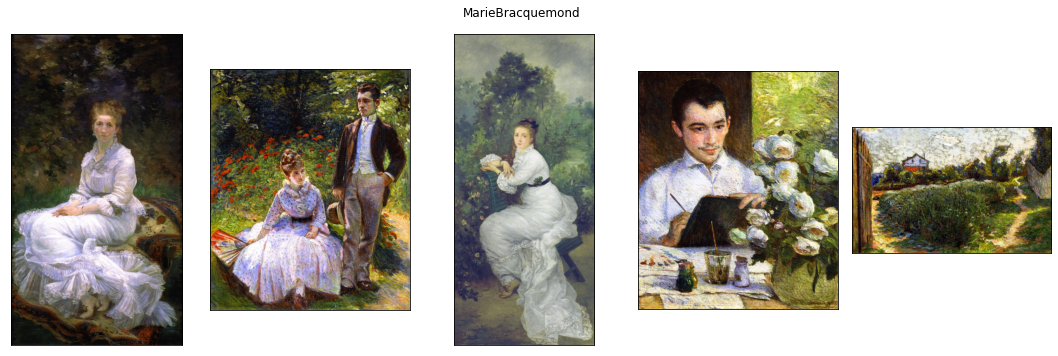

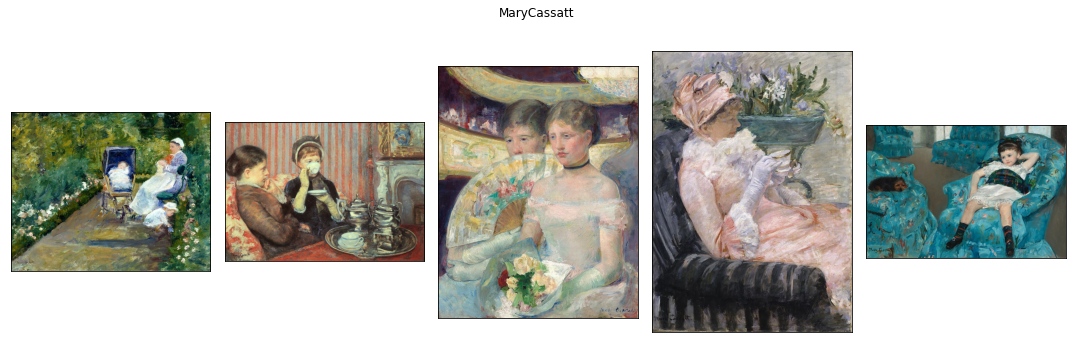

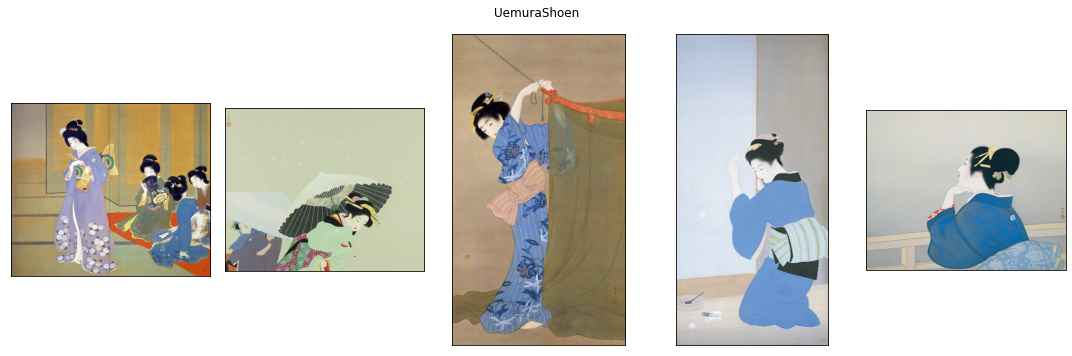

In [41]:
def plot_images_per_artist(filenames, artist):
    plt.figure(figsize=(15, 5)) 
    plt.suptitle(artist)

    for i in range(1, len(filenames)+1):
        plt.subplot(1, len(filenames), i)
        image = cv2.cvtColor(cv2.imread(DIR+filenames[i-1]), cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        plt.xticks([]), plt.yticks([])
    plt.tight_layout()
    plt.show()

artists = df['artist'].value_counts().index.to_numpy()
for artist in artists:
    filenames = list(df[df['artist']==artist].sample(5).filename.to_numpy())
    # print(filenames)
    plot_images_per_artist(filenames, artist)
    print()

#### Функции, возвращающие векторное представление

In [4]:
from skimage.feature import local_binary_pattern
from skimage.color import label2rgb
# settings for LBP
radius = 3
n_points = 8 * radius

def plot_lbp_hist(image_name):

    def overlay_labels(image, lbp, labels):
        mask = np.logical_or.reduce([lbp == each for each in labels])
        return label2rgb(mask, image=image, bg_label=0, alpha=0.5)


    def highlight_bars(bars, indexes):
        for i in indexes:
            bars[i].set_facecolor('r')


    image = cv2.imread(DIR+image_name, 0) #grey-level
    # image = cv2.resize(image, (512, 512))
    lbp = local_binary_pattern(image, n_points, radius, 'uniform')


    def hist(ax, lbp):
        n_bins = int(lbp.max() + 1)
        return ax.hist(lbp.ravel(), density=True, bins=n_bins, range=(0, n_bins),
                    facecolor='0.5')


    # plot histograms of LBP of textures
    fig, (ax_img, ax_hist) = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))
    plt.gray()

    titles = ('edge', 'flat', 'corner')
    w = width = radius - 1
    edge_labels = range(n_points // 2 - w, n_points // 2 + w + 1)
    flat_labels = list(range(0, w + 1)) + list(range(n_points - w, n_points + 2))
    i_14 = n_points // 4            # 1/4th of the histogram
    i_34 = 3 * (n_points // 4)      # 3/4th of the histogram
    corner_labels = (list(range(i_14 - w, i_14 + w + 1)) +
                    list(range(i_34 - w, i_34 + w + 1)))

    label_sets = (edge_labels, flat_labels, corner_labels)

    for ax, labels in zip(ax_img, label_sets):
        ax.imshow(overlay_labels(image, lbp, labels))

    for ax, labels, name in zip(ax_hist, label_sets, titles):
        counts, _, bars = hist(ax, lbp)
        highlight_bars(bars, labels)
        ax.set_ylim(top=np.max(counts[:-1]))
        ax.set_xlim(right=n_points + 2)
        ax.set_title(name)

    ax_hist[0].set_ylabel('Percentage')
    for ax in ax_img:
        ax.axis('off')

def get_lbp_embedding(image_name):
    path_to_img = DIR+image_name
    # print(path_to_img)

    image = cv2.imread(path_to_img, 0) #grey-level
    lbp = local_binary_pattern(image, n_points, radius, 'uniform')

    n_bins = int(lbp.max() + 1) # 26
    hist, _ = np.histogram(lbp, density=True, bins=n_bins, range=(0, n_bins))

    return hist, 'LBP'

# print(get_lbp_embedding('MarieBracquemond/1890-4.jpg'))
# print(get_lbp_embedding('FridaKahlo/moses.jpg'))

# plot_lbp_hist('UemuraShoen/4006-large_flakes_of_snow.jpg')


In [46]:
def get_hog_embedding(image_name):
    def plot(image, hog_image):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
        ax1.axis('off')
        ax1.imshow(image, cmap=plt.cm.gray)
        ax1.set_title('Input image')

        # Rescale histogram for better display
        hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

        ax2.axis('off')
        ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
        ax2.set_title('Histogram of Oriented Gradients')
        plt.show()

    path_to_img = DIR+image_name
    # print(path_to_img)
    image = cv2.imread(path_to_img)
    image = cv2.resize(image, (W, H))
    # print(image.shape)
    fd, hog_image = hog(image, orientations=8, pixels_per_cell=(40, 40), #feature_vector=True,
                    cells_per_block=(1, 1), visualize=True, channel_axis=-1)

    # plot(image, hog_image)

    return fd, 'HOG'

In [40]:
def get_glcm_embedding(image_name):
    def plot(image):
        w = image.shape[1] - PATCH_SIZE
        h = image.shape[0] - PATCH_SIZE
        # select some patches from grassy areas of the image
        grass_locations = [(np.random.randint(h), np.random.randint(w)), 
                            (np.random.randint(h), np.random.randint(w)), 
                            (np.random.randint(h), np.random.randint(w)),
                            (np.random.randint(h), np.random.randint(w))]
        grass_patches = []
        for loc in grass_locations:
            grass_patches.append(image[loc[0]:loc[0] + PATCH_SIZE,
                                    loc[1]:loc[1] + PATCH_SIZE])

        # select some patches from sky areas of the image
        sky_locations = [(np.random.randint(h), np.random.randint(w)), 
                            (np.random.randint(h), np.random.randint(w)), 
                            (np.random.randint(h), np.random.randint(w)),
                            (np.random.randint(h), np.random.randint(w))]
        sky_patches = []
        for loc in sky_locations:
            sky_patches.append(image[loc[0]:loc[0] + PATCH_SIZE,
                                    loc[1]:loc[1] + PATCH_SIZE])

        # compute some GLCM properties each patch
        xs = []
        ys = []
        for patch in (grass_patches + sky_patches):
            if patch.size!=0:
                glcm = graycomatrix(patch, distances=[5], angles=[0], levels=256,
                                    symmetric=True, normed=True)
                xs.append(graycoprops(glcm, 'dissimilarity')[0, 0])
                ys.append(graycoprops(glcm, 'correlation')[0, 0])

        # create the figure
        fig = plt.figure(figsize=(8, 8))

        # display original image with locations of patches
        ax = fig.add_subplot(3, 2, 1)
        ax.imshow(image, cmap=plt.cm.gray,
                vmin=0, vmax=255)
        for (y, x) in grass_locations:
            ax.plot(x + PATCH_SIZE / 2, y + PATCH_SIZE / 2, 'gs')
        for (y, x) in sky_locations:
            ax.plot(x + PATCH_SIZE / 2, y + PATCH_SIZE / 2, 'bs')
        ax.set_xlabel('Original Image')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis('image')

        # for each patch, plot (dissimilarity, correlation)
        ax = fig.add_subplot(3, 2, 2)
        ax.plot(xs[:len(grass_patches)], ys[:len(grass_patches)], 'go',
                label='Patch (1 class)')
        ax.plot(xs[len(grass_patches):], ys[len(grass_patches):], 'bo',
                label='Patch (2 class)')
        ax.set_xlabel('GLCM Dissimilarity')
        ax.set_ylabel('GLCM Correlation')
        ax.legend()

        # display the image patches
        for i, patch in enumerate(grass_patches):
            ax = fig.add_subplot(3, len(grass_patches), len(grass_patches)*1 + i + 1)
            ax.imshow(patch, cmap=plt.cm.gray,
                    vmin=0, vmax=255)
            ax.set_xlabel('Patch (1 class) %d' % (i + 1))

        for i, patch in enumerate(sky_patches):
            ax = fig.add_subplot(3, len(sky_patches), len(sky_patches)*2 + i + 1)
            ax.imshow(patch, cmap=plt.cm.gray,
                    vmin=0, vmax=255)
            ax.set_xlabel('Patch (2 class) %d' % (i + 1))


        # display the patches and plot
        fig.suptitle('Grey level co-occurrence matrix features', fontsize=14, y=1.05)
        plt.tight_layout()
        plt.show()

    path_to_img = DIR+image_name
    image = cv2.imread(path_to_img, 0)
    glcm = graycomatrix(image, distances=[1, 3, 5], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256,
                        symmetric=True, normed=True)
    # plot(image)
    
    features = []
    for feature in GLSM_FEATURES:
        features.append(graycoprops(glcm, feature))
    
    return np.array(features).ravel(), 'GLCM'

# get_glcm_embedding('MarieBracquemond/1877-2.jpg')


In [37]:
from scipy.stats import skew
def get_color_moments(image_name):
    
    path_to_img = DIR+image_name
    image = cv2.imread(path_to_img)
    
    R = image[:, :, 0]
    G = image[:, :, 1]
    B = image[:, :, 2]
    
    meanR = np.mean(R)
    meanG = np.mean(G)
    meanB = np.mean(B)

    stdR = np.std(R)
    stdG = np.std(G)
    stdB = np.std(B)

    # differenceR = 0.0
    # differenceG = 0.0
    # differenceB = 0.0

    # for i in range (len(image)):
    #     for j in range (len(image[0])):
    #         differenceR = differenceR - np.float_power((R[i][j] - meanR), 3)
    #         differenceG = differenceG - np.float_power((G[i][j] - meanG), 3)
    #         differenceB = differenceB - np.float_power((B[i][j] - meanB), 3)

    # N = len(image) * len(image[0])

    # if differenceR<0:
    #     skewnessR = -np.float_power((-differenceR/N), 1/3.)
    # else:
    #     skewnessR = np.float_power((differenceR/N), 1/3.)

    # if differenceG<0:
    #     skewnessG = -np.float_power((-differenceG/N), 1/3.)
    # else:
    #     skewnessG = np.float_power((differenceG/N), 1/3.)

    # if differenceB<0:
    #     skewnessB = -np.float_power((-differenceB/N), 1/3.)
    # else:
    #     skewnessB = np.float_power((differenceB/N), 1/3.)
    skewnessR = skew(R.ravel())
    skewnessG = skew(G.ravel())
    skewnessB = skew(B.ravel())

    return [meanR, meanG, meanB, stdR, stdG, stdB, skewnessR, skewnessG, skewnessB], 'MOMENTS'

# get_color_moments('MarieBracquemond/1877-2.jpg')

#### Базовый классификатор, принимающий функцию предобработки

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

class Classifier:
    def __init__(self, prep_function, dimred=None):
        self.prep_function = prep_function
        self.name = None
        self.model = None
        self.scaler = None
        self.train_score = None
        self.dimred = None
        if dimred:
            self.dimred = dimred
    
    def show_conf(self, x, y):
        y_pred = self.predict(x)
        cm = confusion_matrix(y, y_pred, labels=self.model.classes_)

        plt.figure(figsize=(10,8))
        plt.title(f'Confusion Matrix, {self.name}')

        df_cm = pd.DataFrame(cm, index = le.classes_, columns = le.classes_)

        ax = sns.heatmap(df_cm, annot=True, linewidths=.5, cbar_kws={"shrink": .5}, 
                          cmap=sns.diverging_palette(230, 20, as_cmap=True))
        ax.set_xticklabels(le.classes_)
        ax.set_yticklabels(le.classes_)
    
        ax.set(ylabel='True Label', xlabel='Predicted Label')

        return y_pred

    def _preprocess(self, image_names: np.array):
        return np.array([self.prep_function(image)[0] for image in image_names]), self.prep_function(image_names.iloc[0])[1]
    
    def fit(self, image_names, labels):
        print('Fitting started.')
        preprocessed, self.name = self._preprocess(image_names)
        self.scaler = StandardScaler()
        preprocessed = self.scaler.fit_transform(preprocessed)

        if self.dimred:
            preprocessed = self.dimred.fit_transform(preprocessed)

        print('After preprocessing shape of the data: ', preprocessed.shape)

        clf = KNeighborsClassifier(n_neighbors=1)
        clf.fit(preprocessed, labels)
        print('Fitting ended.')
        self.train_score = clf.score(preprocessed, labels) # всегда = 1.0
        self.model = clf

    def predict(self, image_names):
        print(f'{self.name}. Prediction started.')
        preprocessed, _ = self._preprocess(image_names)
        preprocessed = self.scaler.transform(preprocessed)
        if self.dimred:
            preprocessed = self.dimred.transform(preprocessed)
        return self.model.predict(preprocessed)

    def score(self, image_names, labels):
        print(f'{self.name}. Scoring started.')
        predicted = self.predict(image_names)
        return predicted, np.sum(predicted==labels)/labels.shape[0]

    def get_neighbour(self, img_path):
        image_name = pd.Series([img_path])
        preprocessed, _ = self._preprocess(image_name)
        preprocessed = self.scaler.transform(preprocessed)
        if self.dimred:
            preprocessed = self.dimred.transform(preprocessed)
        return self.model.kneighbors(preprocessed, 1)

#### Трейн/тест

In [81]:
data = df[['filename', 'label']]
x_train, mx_test, y_train, my_test = train_test_split(data['filename'], data['label'], stratify=data['label'], train_size=0.7)
# x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, stratify=y_train, train_size=0.7)
# x_test == mx_train, y_test == my_train

In [9]:
print('Тестовый (для метаалгоритма):', mx_test.shape)
print('Обучающий для каждого алгоритма:', x_train.shape)
# print('Тестовый для каждого алгоритма и обучающий для метаалгоритма', x_test.shape)

Тестовый (для метаалгоритма): (29,)
Обучающий для каждого алгоритма: (66,)


In [ ]:
# from sklearn.decomposition import PCA 
# hog_clf = Classifier(get_hog_embedding, PCA(n_components=9))
# y_test_pred_hog = hog_clf.show_conf(x_test, y_test)

#### Первый алгоритм: LBP

In [83]:
lbp_clf = Classifier(get_lbp_embedding)

lbp_clf.fit(x_train, y_train) # около 40 секунд
lbp_clf.score(mx_test, my_test)[1] # около 20 секунд 

Fitting started.
After preprocessing shape of the data:  (66, 26)
Fitting ended.
LBP. Scoring started.
LBP. Prediction started.


0.3448275862068966

In [ ]:
# img_path_ = 'Barocco/Hristos-u-stolba-Karavadzho.jpg'

clfs = [lbp_clf, glcm_clf, moments_clf]
# distances = []
# image_index = []
# for clf in clfs:
#     tmp = clf.get_neighbour(img_path_)
#     distances.append(tmp[0][0][0])
#     image_index.append(tmp[1][0][0])

# min_dist_ind = np.argmin(np.array(distances))
# simil_image = image_index[min_dist_ind]
# x_train.ravel()[simil_image]

LBP. Prediction started.


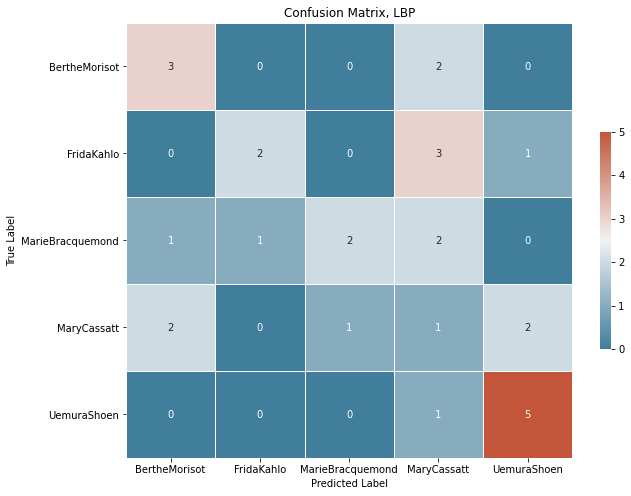

In [66]:
y_test_pred_lbp = lbp_clf.show_conf(mx_test, my_test) # 16 секунды

#### Второй алгоритм : GLCM

In [84]:
glcm_clf = Classifier(get_glcm_embedding)
glcm_clf.fit(x_train, y_train) # около 12 секунд 
glcm_clf.score(mx_test, my_test)[1]

Fitting started.
After preprocessing shape of the data:  (66, 72)
Fitting ended.
GLCM. Scoring started.
GLCM. Prediction started.


0.3448275862068966

GLCM. Prediction started.


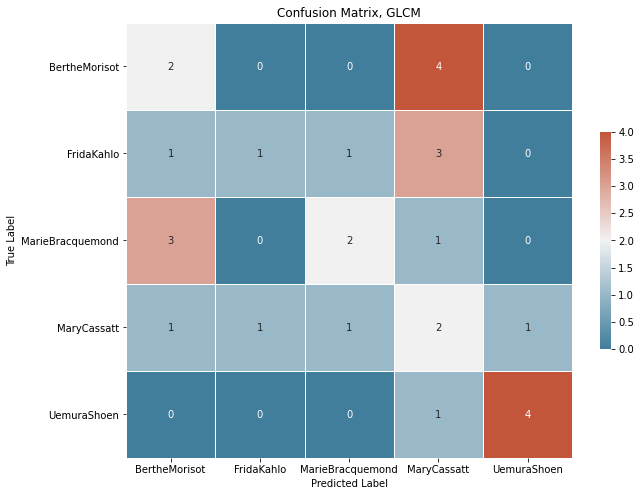

In [73]:
y_test_pred_glcm = glcm_clf.show_conf(mx_test, my_test) 

#### Третий алгоритм: COLOR MOMENTS

In [85]:
moments_clf = Classifier(get_color_moments)
moments_clf.fit(x_train, y_train) # около 5 с
# moments_clf.score(x_test, y_test) # около 5 с
moments_clf.score(mx_test, my_test)[1]

Fitting started.
After preprocessing shape of the data:  (66, 9)
Fitting ended.
MOMENTS. Scoring started.
MOMENTS. Prediction started.


0.27586206896551724

MOMENTS. Prediction started.


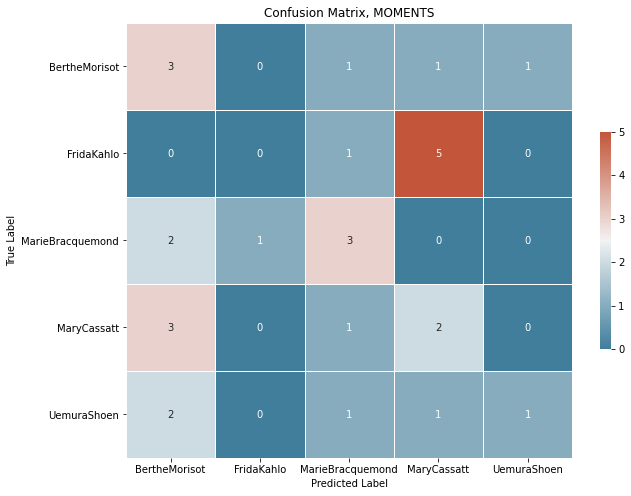

In [80]:
y_test_pred_moments = moments_clf.show_conf(mx_test, my_test) 

In [55]:
res = pd.DataFrame()
res['lbp'] = y_test_pred_lbp
res['glcm'] = y_test_pred_glcm
res['moms'] = y_test_pred_moments
res['labels'] = my_test.to_numpy()
votes = res[['lbp', 'glcm', 'moms']].apply(lambda x: np.argmax(np.bincount(np.array(x))), axis=1)
np.sum(votes==res['labels'])/votes.shape[0]

0.6551724137931034

In [57]:
def get_neighbour(img_path_):
    # img_path_ = 'Barocco/Hristos-u-stolba-Karavadzho.jpg'

    distances = []
    image_index = []
    for clf in clfs:
        tmp = clf.get_neighbour(img_path_)
        distances.append(tmp[0][0][0])
        image_index.append(tmp[1][0][0])

    min_dist_ind = np.argmin(np.array(distances))
    simil_image = image_index[min_dist_ind]
    return x_train.ravel()[simil_image]

get_neighbour('MarieBracquemond/pierre.jpg')

'MaryCassatt/Mary_Cassat_-_Lilacs_in_a_Window_-_MMA_1997.207.jpg'

In [58]:
clfs = [lbp_clf, glcm_clf, moments_clf]

def meta_predict(clfs, img_path):
    votes = []
    for clf in clfs:
        votes.append(clf.predict(pd.Series([img_path]))[0])
    # print(votes)
    return le.classes_[np.argmax(np.bincount(np.array(votes)))]

x_test_pred = [(le.transform([meta_predict(clfs, x)]))[0] for x in mx_test]
print(np.sum(x_test_pred==my_test.to_numpy())/my_test.shape[0])

LBP. Prediction started.
GLCM. Prediction started.
MOMENTS. Prediction started.
LBP. Prediction started.


KeyboardInterrupt: 

In [27]:
data = df[['filename', 'label']]
x_train, mx_test, y_train, my_test = train_test_split(data['filename'], data['label'], stratify=data['label'], train_size=0.7)
print('Тестовый (для метаалгоритма):', mx_test.shape)
print('Обучающий для каждого алгоритма:', x_train.shape)


hog_clf = Classifier(get_hog_embedding, PCA(n_components=9))
hog_clf.fit(x_train, y_train) # около 1 минуты 20 секунд
y_test_pred_hog, hog_score = hog_clf.score(mx_test, my_test)
print('HOG: ', hog_score)

glcm_clf = Classifier(get_glcm_embedding)
glcm_clf.fit(x_train, y_train) # около 2 минут
y_test_pred_glcm, glcm_score = glcm_clf.score(mx_test, my_test)
print('GLCM: ', glcm_score)

moments_clf = Classifier(get_color_moments)
moments_clf.fit(x_train, y_train) # около 2 минут
y_test_pred_moments, moments_score = moments_clf.score(mx_test, my_test)
print('MOMENTS: ', moments_score)

res = pd.DataFrame()
res['hog'] = y_test_pred_hog
res['glcm'] = y_test_pred_glcm
res['moms'] = y_test_pred_moments
res['labels'] = my_test.to_numpy()
votes = res[['hog', 'glcm', 'moms']].apply(lambda x: np.argmax(np.bincount(np.array(x))), axis=1)
print('MAJOR: ', np.sum(votes==res['labels'])/votes.shape[0])


Тестовый (для метаалгоритма): (33,)
Обучающий для каждого алгоритма: (77,)
Fitting started.
After preprocessing shape of the data:  (77, 9)
Fitting ended.
HOG. Scoring started.
HOG. Prediction started.
HOG:  0.2727272727272727
Fitting started.
After preprocessing shape of the data:  (77, 72)
Fitting ended.
GLCM. Scoring started.
GLCM. Prediction started.
GLCM:  0.3939393939393939
Fitting started.
After preprocessing shape of the data:  (77, 9)
Fitting ended.
MOMENTS. Scoring started.
MOMENTS. Prediction started.
MOMENTS:  0.5454545454545454
MAJOR:  0.45454545454545453


#### Метаалгоритм

In [21]:
class MetaClassifier:
    def __init__(self, clfs:list, alg):
        self.clfs = clfs # already fitted
        self.model = alg
        self.scaler = None
        self.features = [i.name for i in clfs]
        self.name = 'META'

    def show_conf(self, y_true, y_pred):
        cm = confusion_matrix(y_true, y_pred, labels=self.model.classes_)

        plt.figure(figsize=(10,8))
        plt.title(f'Confusion Matrix, {self.name}')

        df_cm = pd.DataFrame(cm, index = le.classes_, columns = le.classes_)

        ax = sns.heatmap(df_cm, annot=True, linewidths=.5, cbar_kws={"shrink": .5}, 
                          cmap=sns.diverging_palette(230, 20, as_cmap=True))
        ax.set_xticklabels(le.classes_)
        ax.set_yticklabels(le.classes_)
    
        ax.set(ylabel='True Label', xlabel='Predicted Label')

    def preprocess(self, x, y):
        data = pd.DataFrame()
        data['filename'] = x
        if isinstance(y, np.ndarray) or isinstance(y, pd.Series):
            data['label'] = y
        data.reset_index(drop=True, inplace=True)
        for clf in clfs:
            data[clf.name] = clf.predict(x)
        
        if isinstance(y, np.ndarray) or isinstance(y, pd.Series):
            return data[self.features], data['label']
        else:
            return data[self.features], None

    def fit(self, x, y):
        x, y = self.preprocess(x, y)
        self.scaler = StandardScaler()
        preprocessed = self.scaler.fit_transform(x)
        self.model.fit(x.values, y.values)

    def predict(self, x):
        x, _ = self.preprocess(x, None)
        preprocessed = self.scaler.transform(x)
        return self.model.predict(x.values)

    def score(self, x, y):
        x, y = self.preprocess(x, y)
        preprocessed = self.scaler.transform(x)
        return self.model.score(x.values, y.values)      
        

In [36]:
get_hog_embedding(mx_test[5])[0]

array([0.35355339, 0.35355339, 0.35355339, ..., 0.35355339, 0.35355339,
       0.35355339])

In [119]:
clfs = [hog_clf, glcm_clf, moments_clf] # 
mclf = MetaClassifier(clfs, KNeighborsClassifier(n_neighbors=1))
mclf.fit(x_test, y_test) # 1 минута 50 секунд

HOG. Prediction started.
GLCM. Prediction started.
MOMENTS. Prediction started.


In [120]:
mclf.score(mx_test, my_test) # 1 минута 20 секунд 0.17142857142857143

HOG. Prediction started.
GLCM. Prediction started.
MOMENTS. Prediction started.


0.36363636363636365

HOG. Prediction started.
GLCM. Prediction started.
MOMENTS. Prediction started.


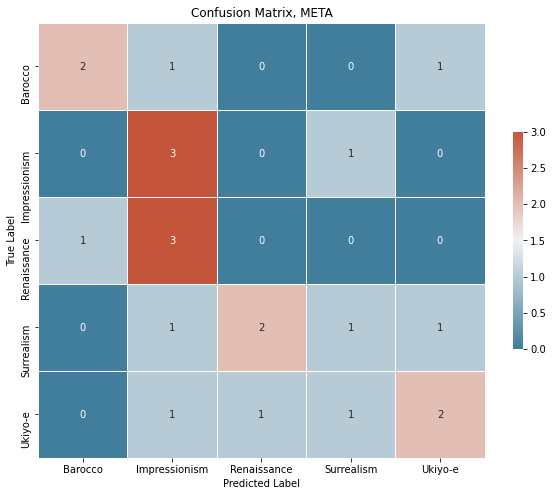

In [121]:
my_test_pred = mclf.predict(mx_test)
mclf.show_conf(my_test, my_test_pred)

#### Всё за раз

In [60]:
COUNT = 5
prep_funcs = [get_lbp_embedding, get_glcm_embedding, get_color_moments]
# data = df[['filename', 'label']]
scoress = {i:[] for i in range(len(prep_funcs)+1)}

for i in range(COUNT):
    x_train, mx_test, y_train, my_test = train_test_split(data['filename'], data['label'], stratify=data['label'], train_size=0.7)
    # x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, stratify=y_train, train_size=0.7)

    clfs = []
    predicteds = []
    for j, func in enumerate(prep_funcs):
        clf = Classifier(func)
        clf.fit(x_train, y_train)
        clfs.append(clf)
        predicted, score = clf.score(mx_test, my_test)
        predicteds.append(predicted)
        scoress[j].append(score)
        print()
    
    res = pd.DataFrame()
    res['lbp'] = predicteds[0]
    res['glcm'] = predicteds[1]
    res['moms'] = predicteds[2]
    res['labels'] = my_test.to_numpy()
    votes = res[['lbp', 'glcm', 'moms']].apply(lambda x: np.argmax(np.bincount(np.array(x))), axis=1)
    scoress[len(prep_funcs)].append(np.sum(votes==res['labels'])/votes.shape[0])

Fitting started.
After preprocessing shape of the data:  (66, 26)
Fitting ended.
LBP. Scoring started.
LBP. Prediction started.

Fitting started.
After preprocessing shape of the data:  (66, 72)
Fitting ended.
GLCM. Scoring started.
GLCM. Prediction started.

Fitting started.
After preprocessing shape of the data:  (66, 9)
Fitting ended.
MOMENTS. Scoring started.
MOMENTS. Prediction started.

Fitting started.
After preprocessing shape of the data:  (66, 26)
Fitting ended.
LBP. Scoring started.
LBP. Prediction started.

Fitting started.
After preprocessing shape of the data:  (66, 72)
Fitting ended.
GLCM. Scoring started.
GLCM. Prediction started.

Fitting started.
After preprocessing shape of the data:  (66, 9)
Fitting ended.
MOMENTS. Scoring started.
MOMENTS. Prediction started.

Fitting started.
After preprocessing shape of the data:  (66, 26)
Fitting ended.
LBP. Scoring started.
LBP. Prediction started.

Fitting started.
After preprocessing shape of the data:  (66, 72)
Fitting ended

In [61]:
scoress

{0: [0.4482758620689655,
  0.3793103448275862,
  0.4827586206896552,
  0.4827586206896552,
  0.5172413793103449],
 1: [0.4827586206896552,
  0.5517241379310345,
  0.4482758620689655,
  0.3103448275862069,
  0.41379310344827586],
 2: [0.41379310344827586,
  0.3103448275862069,
  0.3793103448275862,
  0.3103448275862069,
  0.3103448275862069],
 3: [0.5862068965517241,
  0.4827586206896552,
  0.4827586206896552,
  0.41379310344827586,
  0.4827586206896552]}

In [63]:
scoress

{0: [0.4482758620689655,
  0.3793103448275862,
  0.4827586206896552,
  0.4827586206896552,
  0.5172413793103449],
 1: [0.4827586206896552,
  0.5517241379310345,
  0.4482758620689655,
  0.3103448275862069,
  0.41379310344827586],
 2: [0.41379310344827586,
  0.3103448275862069,
  0.3793103448275862,
  0.3103448275862069,
  0.3103448275862069],
 3: [0.5862068965517241,
  0.4827586206896552,
  0.4827586206896552,
  0.41379310344827586,
  0.4827586206896552]}

0.46206896551724136 +- 0.046774689538794975
0.4413793103448276 +- 0.07983335795027742
0.3448275862068965 +- 0.043617622898874185
0.4896551724137931 +- 0.055172413793103434


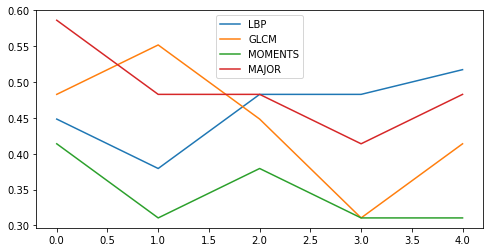

In [62]:
types = ['LBP', 'GLCM', 'MOMENTS', 'MAJOR']
plt.figure(figsize=(8, 4))
for type in scoress:
    score = np.array(scoress[type])
    print(score.mean(), '+-', score.std())
    plt.plot(score, label=f'{types[type]}')
plt.legend()
plt.show()

#### GUI

In [190]:
mx_test

94                    Ukiyo-e/618px-03_-_Sukiyagahsi.jpg
18      Barocco/Svyatoe-Semeystvo-Antonisa-van-Deyka.jpg
96     Ukiyo-e/De_pruimenboomgaard_te_Kameido-Rijksmu...
24     Impressionism/723px-Claude_Monet_-_Woman_with_...
51                   Renaissance/God2-Sistine_Chapel.jpg
27                    Impressionism/Claude_Monet_024.jpg
44     Renaissance/1199px-Sandro_Botticelli_-_La_nasc...
7      Barocco/Judit_decapitando_a_Holofernes,_por_Ar...
109              Ukiyo-e/The_Great_Wave_off_Kanagawa.jpg
3      Barocco/anton-van-deik-portret-karla-i-na-ohot...
53     Renaissance/Leonardo_da_Vinci_Madonna_of_the_C...
37                    Impressionism/pissaro_red_roof.jpg
99                 Ukiyo-e/Hiroshige_le_Lac_d'Hakone.jpg
50      Renaissance/995px-Titian_Bacchus_and_Ariadne.jpg
1      Barocco/adrian-vann-de-velde-ferma-s-mertvym-d...
26     Impressionism/Auguste_Renoir_-_La_Grenouillre.jpg
79     Surrealism/salvador-dali-nevolnichii-rynok-s-i...
90     Ukiyo-e/1200px-Hiroshige

In [201]:
clfs = [hog_clf, glcm_clf, moments_clf]
img_path = 'Barocco/Hristos-u-stolba-Karavadzho.jpg'
img_path = 'Impressionism/pissaro_red_roof.jpg'
meta_predict(clfs, img_path)

HOG. Prediction started.
GLCM. Prediction started.
MOMENTS. Prediction started.


'Impressionism'

In [204]:
meta_predict_x_test = []
for test in mx_test:
    meta_predict_x_test.append(meta_predict(clfs, test))


MOMENTS. Prediction started.
HOG. Prediction started.
GLCM. Prediction started.
MOMENTS. Prediction started.
HOG. Prediction started.
GLCM. Prediction started.
MOMENTS. Prediction started.
HOG. Prediction started.
GLCM. Prediction started.
MOMENTS. Prediction started.
HOG. Prediction started.
GLCM. Prediction started.
MOMENTS. Prediction started.
HOG. Prediction started.
GLCM. Prediction started.
MOMENTS. Prediction started.
HOG. Prediction started.
GLCM. Prediction started.
MOMENTS. Prediction started.
HOG. Prediction started.
GLCM. Prediction started.
MOMENTS. Prediction started.
HOG. Prediction started.
GLCM. Prediction started.
MOMENTS. Prediction started.
HOG. Prediction started.
GLCM. Prediction started.
MOMENTS. Prediction started.
HOG. Prediction started.
GLCM. Prediction started.
MOMENTS. Prediction started.
HOG. Prediction started.
GLCM. Prediction started.
MOMENTS. Prediction started.
HOG. Prediction started.
GLCM. Prediction started.
MOMENTS. Prediction started.
HOG. Predic

In [206]:
meta_predict_x_test_ = le.transform(meta_predict_x_test)

In [215]:
meta_predict_x_test_

array([4, 0, 4, 0, 0, 1, 0, 0, 4, 2, 2, 1, 4, 1, 0, 1, 3, 0, 1, 2, 2, 1,
       0, 2, 2, 0, 0, 2, 0, 1, 0, 1, 4])

In [214]:
my_test.to_numpy()

array([4, 0, 4, 1, 2, 1, 2, 0, 4, 0, 2, 1, 4, 2, 0, 1, 3, 4, 4, 3, 0, 1,
       1, 2, 3, 3, 0, 3, 0, 1, 3, 2, 4])

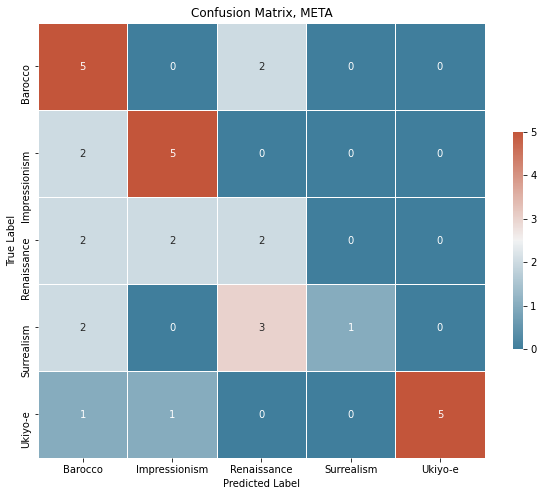

In [223]:
cm = confusion_matrix(my_test.to_numpy(), meta_predict_x_test_, labels=np.array([0, 1, 2, 3, 4]))

plt.figure(figsize=(10,8))
plt.title(f'Confusion Matrix, META')

df_cm = pd.DataFrame(cm, index = le.classes_, columns = le.classes_)

ax = sns.heatmap(df_cm, annot=True, linewidths=.5, cbar_kws={"shrink": .5}, 
                    cmap=sns.diverging_palette(230, 20, as_cmap=True))
ax.set_xticklabels(le.classes_)
ax.set_yticklabels(le.classes_)

ax.set(ylabel='True Label', xlabel='Predicted Label')
plt.show()

#### neihbours

In [46]:
img_path = ['Barocco/Hristos-u-stolba-Karavadzho.jpg']
styles[hog_clf.predict(pd.Series(img_path))][0]

HOG. Prediction started.


'Barocco'